In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

# Inspecting and Preparing Data

Load in the data and take a glance at what is inside:

In [3]:
pjme = pd.read_csv('PJME_hourly.csv')

In [4]:
# look at data
display(pjme.head())

#look at data types to see if we need to transform
display(pjme.dtypes)

# look at basic statistics of data
display(pjme.describe())

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


Datetime     object
PJME_MW     float64
dtype: object

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


We will have to transform the Datetime column to datetime objects. Luckily, they are using a standard format.

In [5]:
# Transform Datetime column
pjme.Datetime = pd.to_datetime(pjme.Datetime)

/Users/Paul/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.show(*args, **kw)>

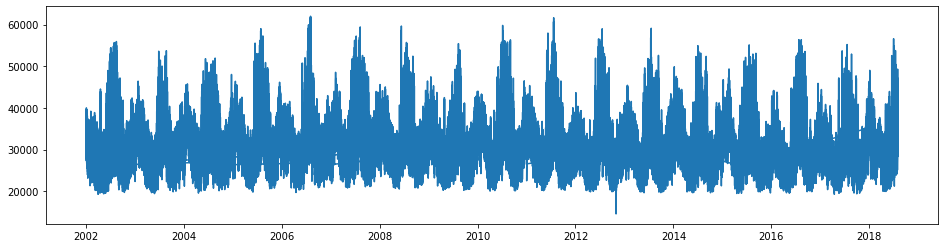

In [6]:
# Plot data
plt.figure(figsize = (16,4))
plt.plot(pjme.Datetime, pjme.PJME_MW)
plt.show

At first glance, our data looks relatively stationary, meaning that it has:
 - constant mean
 - constant variance
 - autocovariance independent of time
 
 This is a basic assumption of most time-series models. We can use a Rickey-Fuller test to ensure confidence that we are working with stationary data. The following block of code for conducting the test was found through the PyData LA 2018 presentation on time series analysis.

In [23]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

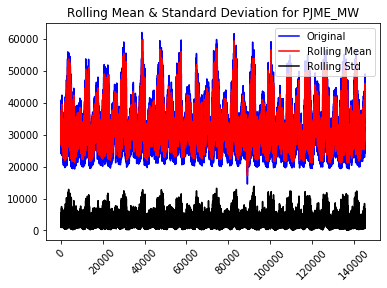

Results of Dickey-Fuller Test:
Test Statistic                -1.882891e+01
p-value                        2.022125e-30
# Lags Used                    7.400000e+01
Number of Observations Used    1.452910e+05
Critical Value (1%)           -3.430395e+00
Critical Value (5%)           -2.861560e+00
Critical Value (10%)          -2.566781e+00
dtype: float64


In [54]:
test_stationarity(df = pjme, ts = 'PJME_MW')

The Dickey-Fuller test p-value is much smaller than 0.05, so we successfully reject the null hypothesis that there is a unit root (that the time series is not stationary)

Since our data is stationary, we will not need to correct it before continuing to ARIMA modeling.

### Choosing ARIMA parameters:

ARIMA uses 3 parameters: p, d, and q.

#### Determining d:

We may want to difference our data (take the relative difference of values instead of the values themselves) to better help our model. Typically, we will choose the degree of differencing that reduces the standard deviation the most. This order of differencing corresponds with the d parameter in the ARIMA model: 

In [87]:
def plot_transformed(df, col1, col2):

    fig, axes = plt.subplots(1,1, figsize = (10,4))
    
    axes.plot(df[col1], color = 'gray')
    axes.plot(df[col2])
    
    #add title and legend
    axes.set_title(f'{col1} and {col2}')
    axes.legend([col1, col2])
    
    plt.show()

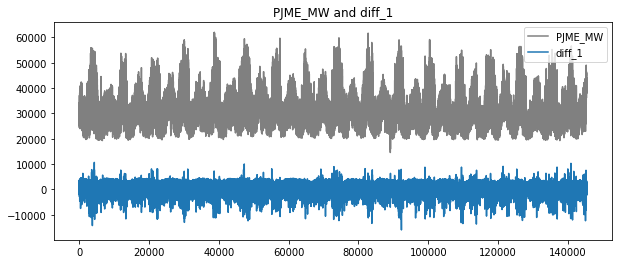

standard deviation: 1576.4275538503607


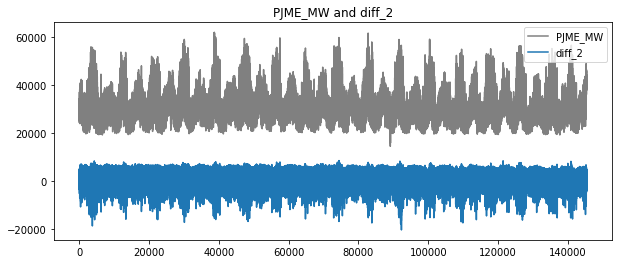

standard deviation: 2915.4986060947676


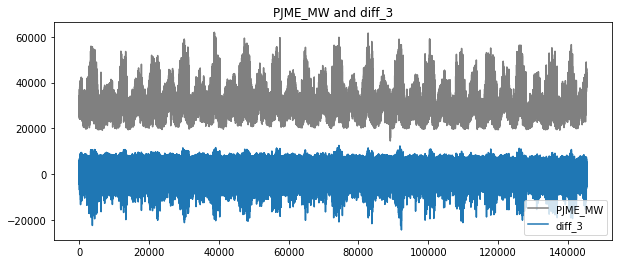

standard deviation: 4106.234563457409


In [89]:
# differencing with a lag of 1:
pjme['diff_1'] = pjme['PJME_MW'].diff()

# differencing with a lag of 2:
pjme['diff_2'] = pjme['PJME_MW'].diff(2)

# differencing with a lag of 2:
pjme['diff_3'] = pjme['PJME_MW'].diff(3)

#plotting:
plot_transformed(pjme, 'PJME_MW', 'diff_1')
print(f'standard deviation: {pjme.diff_1.std()}')

plot_transformed(pjme, 'PJME_MW', 'diff_2')
print(f'standard deviation: {pjme.diff_2.std()}')

plot_transformed(pjme, 'PJME_MW', 'diff_3')
print(f'standard deviation: {pjme.diff_3.std()}')

Differencing of order 1 renders data with the lowest standard deviation, so we will try a d value of 1 at first.

#### Determining p and q:

p is the number of terms to use for the auto-regression portion of the ARIMA model (how many previous terms to include as features in our regressor to determine the next value). We can use a partial auto-correlation plot to give us an idea. This plots the partial correlation between the values relative to the level of lag. partial auto-correlation is analagous to covariance: it is the correlation that is shared solely at that lag value and is not explained by any other shared correlation with other lag values.

q is the number of terms to use for the moving average portion. This can be determined by inspecting the simple auto-correlation plot (rather than partial correlation).

In [83]:
def plot_autocorrelation(df, col):

    from statsmodels.tsa.stattools import acf, pacf

    lag_acf = acf(df[col], nlags = 20, fft = True)
    lag_pacf = pacf(df[col], nlags = 20)

    fig, axes = plt.subplots(1,2, figsize = (10,4))

    # plot ACF
    axes[0].plot(lag_acf)
    axes[0].axhline(y = 0, color = 'gray')
    axes[0].axhline(y = -1.96/(len(df[col])**0.5),
                    color = 'gray',
                    linestyle = '--')
    axes[0].axhline(y = 1.96/(len(df[col])**0.5),
                    color = 'gray',
                    linestyle = '--')
    axes[0].set_title(f'Autocorrelation of {col}')

    # plot PACF
    axes[1].plot(lag_pacf)
    axes[1].axhline(y = 0, color = 'gray')
    axes[1].axhline(y = -1.96/(len(df[col])**0.5),
                    color = 'gray',
                    linestyle = '--')
    axes[1].axhline(y = 1.96/(len(df[col])**0.5),
                    color = 'gray',
                    linestyle = '--')
    axes[1].set_title(f'Partial autocorrelation of {col}')
    
    plt.show()
    

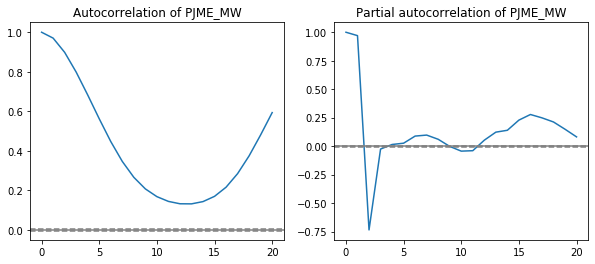

In [84]:
# plotting autocorrelation with no differencing
plot_autocorrelation(pjme, 'PJME_MW')

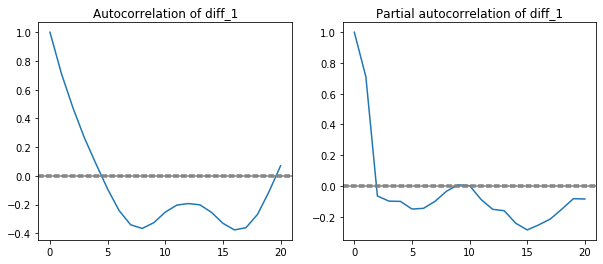

In [86]:
# plotting autocorrelation for differencing of 1
plot_autocorrelation(pjme.iloc[1:-1,:], 'diff_1')

The autocorrelation plots again show that differencing of order 1 is probably the best choice. We choose q where the autocorrelation plot first crosses the significance margin, and we choose p using the same method with the partial autocorrelation plot. This renders values of around 5 and 2, respectively. This, we will continue with:
- p = 2
- d = 1
- q = 5

In [108]:
def run_ARIMA(df, col, params):
    
    from statsmodels.tsa.arima_model import ARIMA
    
    arima = ARIMA(df[col], order = params)
    results = arima.fit()
    
    # error
    rss = sum((results.fittedvalues - df[col][-(len(results.fittedvalues)):])**2)
    rmse = (rss / len(results.fittedvalues))**0.5
    
    # plot results
    fig, ax = plt.subplots(1,1, figsize = (10,4))
    ax.plot(df[col].diff(params[1]), color = 'gray')
    ax.plot(results.fittedvalues, color = 'blue')
    ax.set_title(f'ARIMA with (p, d, q) = {params}')   
    print(f'rmse: {rmse}')
    plt.show()
    
    return results

rmse: 32731.139185198725


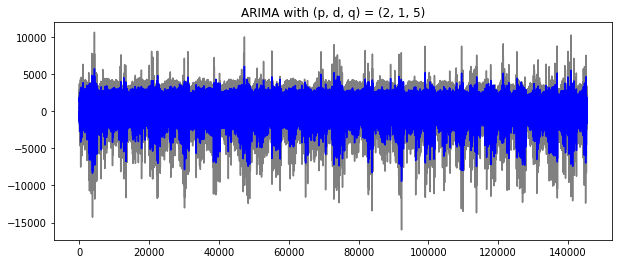

In [109]:
results = run_ARIMA(pjme, 'PJME_MW', (2,1,5))

It apprears our model is at least a decent fit for our data. We can compare it with a more sophisticated method, such as LSTM:

## Univariate LSTM:

Running an LSTM model can be done through Keras, a deep learning library within Tensorflow. We will first run a univariate LSTM model, and then move to a multivariate.

In [207]:
from numpy import array

def get_inputs(sequence, steps):
    '''
    Create inputs for training LSTM with time series data X and y. 
    X will be a array of sequences within the column of length 'steps'.
    y will be a array of the values immediately following those sequences.
    '''
    
    # initialize X and y
    X, y = list(), list()
    
    # create X and y.
    for i in range(len(sequence)):
        
        upper = i+steps
        
        if upper+1 > len(sequence):
            break
            
        X.append(sequence[i:upper])
        y.append(sequence[upper])
    
    return array(X), array(y)

In [239]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import floor

def run_univariate(sequence, n_steps, train_proportion=0.7, n_features=1, LSTM_units=50, 
                   activation='relu', optomizer='adam', loss='mse', epochs=40, verbose=0):

    # create input data
    train_len = floor(train_proportion*len(sequence))
    X, y = get_inputs(list(pjme.PJME_MW[0:train_len]), n_steps)
    X = X.reshape(X.shape[0], X.shape[1], 1) # must be 3-dimensional

    #initialize model
    univariate = Sequential()
    univariate.add(LSTM(LSTM_units, activation=activation, input_shape=(n_steps,n_features)))
    univariate.add(Dense(1))
    univariate.compile(optimizer=optomizer, loss=loss)
    
    #fit model
    univariate.fit(X, y, epochs=epochs, verbose=verbose)

    # test model
    X_test, y_test = get_inputs(list(pjme.PJME_MW[train_len:len(sequence)]), n_steps)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features) # must be 3-dimensional
    y_predict = univariate.predict(X_test, verbose=0)
    
    # print error
    print(f'RMSE: {mean_squared_error(y_test, y_predict)**0.5}')
          
    # plot model
    fig, ax = plt.subplots(1,1, figsize = (10,4))
    ax.plot(y_test, color='gray', label='true')
    ax.plot(y_predict, color='blue', label='predicted')
    ax.set_title(f'Model using step size {n_steps} through {epochs} epochs:')
    ax.legend()
    plt.show()
    
    return univariate

RMSE: 3682.45500390566


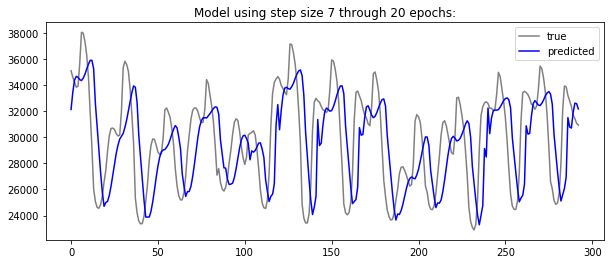

In [257]:
run_univariate(list(pjme.PJME_MW[0:1000]), n_steps = 7, epochs = 20)

## Multivariate LSTM:

Our model can be improved if we include more data. Some of this can be created from the information that we already have, such as the hour of the day, dat of the week, etc. This might give our model more context. For example, it might seem intuitive to us that summer months will lead to higher energy use due to air conditioning, but our model won't be able to take that into account unless we give it seasonal data.

To implement this data, we will have to build a different LSTM model that is capable of using multivariate data.

In [248]:
pjme['hour'] = pjme.Datetime.dt.hour
pjme['dayofweek'] = pjme.Datetime.dt.dayofweek
pjme['dayofmonth'] = pjme.Datetime.dt.day
pjme['dayofyear'] = pjme.Datetime.dt.dayofyear
pjme['month'] = pjme.Datetime.dt.month
pjme['year'] = pjme.Datetime.dt.year
pjme['weekofyear'] = pjme.Datetime.dt.weekofyear

In [249]:
pjme.head()

,Datetime,PJME_MW,diff_1,diff_2,diff_3,trend,seasonal,residual,hour,dayofweek,dayofmonth,dayofyear,month,year,weekofyear
0,2002-12-31 01:00:00,26498.0,NaN,NaN,NaN,NaN,-2023.944074,NaN,1,1,31,365,12,2002,1
1,2002-12-31 02:00:00,25147.0,-1351.0,NaN,NaN,NaN,-2574.127589,NaN,2,1,31,365,12,2002,1
2,2002-12-31 03:00:00,24574.0,-573.0,-1924.0,NaN,NaN,-2421.184225,NaN,3,1,31,365,12,2002,1
3,2002-12-31 04:00:00,24393.0,-181.0,-754.0,-2105.0,NaN,-1907.557123,NaN,4,1,31,365,12,2002,1
4,2002-12-31 05:00:00,24860.0,467.0,286.0,-287.0,NaN,-1187.806182,NaN,5,1,31,365,12,2002,1
